# Create Anomaly Plots 

In [1]:
# package imports
import sys
sys.path.insert(0, '../notebooks')
from imports import *
from shapely.ops import cascaded_union # for uncertainty cones


def is_winter(month):
    return (month <=4) | (month >=10)
mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")

In [2]:
def decadal_mean(ens_number, decade_centers, drought_threshold:float=-1.3,
                     mask_ds: any=mask_ds,future_scenario: str="future"):
    """Takes ensemble member number. Gets all points from decade, returns average for ensemble member
        Set drought_threshold=2.5 if you want to look at all points. 
    """
    
    # file reading
    snowi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/"
                                   f"hist/hist_monthly_ens_{ens_number}.nc")
    snowi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/snowi/"
                                   f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    snowi = xr.concat([snowi_hist, snowi_future], dim='time').sortby('time')

    # corresponding precip 
    precipi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/"
                                     f"hist/hist_monthly_ens_{ens_number}.nc")
    precipi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/precipi/"
                                     f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    precipi = xr.concat([precipi_hist, precipi_future], dim='time').sortby('time')

    # corresponding temp
    tempi_hist   = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/"
                                   f"hist/hist_monthly_ens_{ens_number}.nc")
    tempi_future = xr.open_dataset("/work/Julian.Schmitt/data/zscores/tempi/"
                                   f"{future_scenario}/future_monthly_ens_{ens_number}.nc")
    tempi = xr.concat([tempi_hist, tempi_future], dim='time').sortby('time')
    
    # mask to only snowy cells, select only winter months
    mask20 = mask_ds.expand_dims(dim={'time': snowi.time}) > 20
    snow_sel = snowi.zscores.where(mask20).sel(time=is_winter(snowi['time.month']))
    precip_sel = precipi.zscores.where(mask20).sel(time=is_winter(precipi['time.month']))
    temp_sel = tempi.zscores.where(mask20).sel(time=is_winter(tempi['time.month']))
    
    snow_means, precip_means, temp_means = [], [], []
    for decade_center in decade_centers:
        
        # select time ranges
        decade = (str(decade_center-5), str(decade_center+4))
        snow_decade = snow_sel.sel(time=slice(decade[0], decade[1]))
        precip_decade = precip_sel.sel(time=slice(decade[0], decade[1]))
        temp_decade = temp_sel.sel(time=slice(decade[0], decade[1]))

        # ravel values
        snow_ar = snow_decade.snow.values.ravel()
        precip_ar = precip_decade.snow.values.ravel()
        temp_ar = temp_decade.snow.values.ravel()

        # remove nans - keeps order as mask is identical
        snow_ar = snow_ar[~np.isnan(snow_ar)]
        precip_ar = precip_ar[~np.isnan(precip_ar)]
        temp_ar = temp_ar[~np.isnan(temp_ar)]

        # select drought months
        sd_index = snow_ar < drought_threshold # index
        snow_ar = snow_ar[sd_index]
        precip_ar = precip_ar[sd_index]
        temp_ar = temp_ar[sd_index]
        
        # append mean decadal climatology 
        snow_means.append(np.mean(snow_ar))
        precip_means.append(np.mean(precip_ar))
        temp_means.append(np.mean(temp_ar))
    
    return snow_means, precip_means, temp_means

def uncertainty_cone(means_ar, times, alpha):
    """Takes array of ensemble member arrays of decadal snow, precip, and temp means.
         - Returns shapely cone of uncertainty for plotting
    """
    snow_means, prec_means, temp_means = [], [], []
    snow_cis, prec_cis, temp_cis = [], [], []
    # loop through decades
    for ind, decade in enumerate(times):
        # extract snow, precip, temp values for all ensemble members for specific decade
        snow_val_dec = [means_ar[i][0][ind] for i in range(30)]
        prec_val_dec = [means_ar[i][1][ind] for i in range(30)]
        temp_val_dec = [means_ar[i][2][ind] for i in range(30)]

        # get means and CIs
        snow_mean, prec_mean, temp_mean = np.mean(snow_val_dec), np.mean(prec_val_dec), np.mean(temp_val_dec)
        CI_prec = st.t.interval(alpha=alpha, df = len(prec_val_dec)-1, loc= prec_mean, scale=st.sem(prec_val_dec))
        CI_temp = st.t.interval(alpha= alpha, df = len(temp_val_dec)-1, loc= temp_mean, scale=st.sem(temp_val_dec))

        # append to list of vals
        snow_means.append(snow_mean)
        prec_means.append(prec_mean)
        temp_means.append(temp_mean)

        prec_cis.append(CI_prec)
        temp_cis.append(CI_temp)
    
    # get CI radii
    prec_radii = np.array([p[1]-p[0] for p in prec_cis])/2 # divide by 2 to get radius
    temp_radii = np.array([t[1]-t[0] for t in temp_cis])/2

    # get ellipses from ensemble mean and CI radii
    thetas = np.linspace(0, 2 * np.pi, 360) # nice fine resolution
    temp_means, prec_means = np.array(temp_means), np.array(prec_means)
    polygon_x = temp_means[:,None] + temp_radii[:,None] * np.sin(thetas)
    polygon_y = prec_means[:,None] + prec_radii[:,None] * np.cos(thetas)

    # make ellipses points into shapely polygon objects
    ps = [Polygon(i) for i in np.dstack((polygon_x, polygon_y))]

    # list of convex hulls of subsequent circles
    n = range(len(ps)-1)
    convex_hulls = [MultiPolygon([ps[i], ps[i+1]]).convex_hull for i in n]

    # Concat to get cone of uncertainty
    cone = cascaded_union(convex_hulls)
    return snow_means, prec_means, temp_means, cone

In [3]:
%%time 
# compute all means for RCP8.5
times = np.arange(1925, 2100, 10)
ncores = os.cpu_count() # use all available cores
all_means = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times) for i in range(1,31))
all_means245 = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times, -1.3, mask_ds, "future245") 
                                       for i in range(1,31))

CPU times: user 320 ms, sys: 125 ms, total: 445 ms
Wall time: 5.03 s


In [4]:
# generate uncertainty cones for RCP 4.5 and 8.5 values
snow_mean45, prec_mean45, temp_mean45, cone_45 = uncertainty_cone(all_means245, times, 0.95)
snow_mean85, prec_mean85, temp_mean85, cone_85 = uncertainty_cone(all_means, times, 0.95)

In [5]:
# compute means and uncertainty cones for all drought events
all_clim_means85 = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times, 2.5, mask_ds, "future")
                                         for i in range(1,31))
all_clim_means45 = Parallel(n_jobs=ncores)(delayed(decadal_mean)(str(i).zfill(2), times, 2.5, mask_ds, 
                                                                  "future245") for i in range(1,31))

# generate uncertainty cones for RCP 4.5 and 8.5 values
clim_snow_m45, clim_prec_m45, clim_temp_m45, clim_cone_45 = uncertainty_cone(all_clim_means45, times, 0.95)
clim_snow_m85, clim_prec_m85, clim_temp_m85, clim_cone_85 = uncertainty_cone(all_clim_means85, times, 0.95)

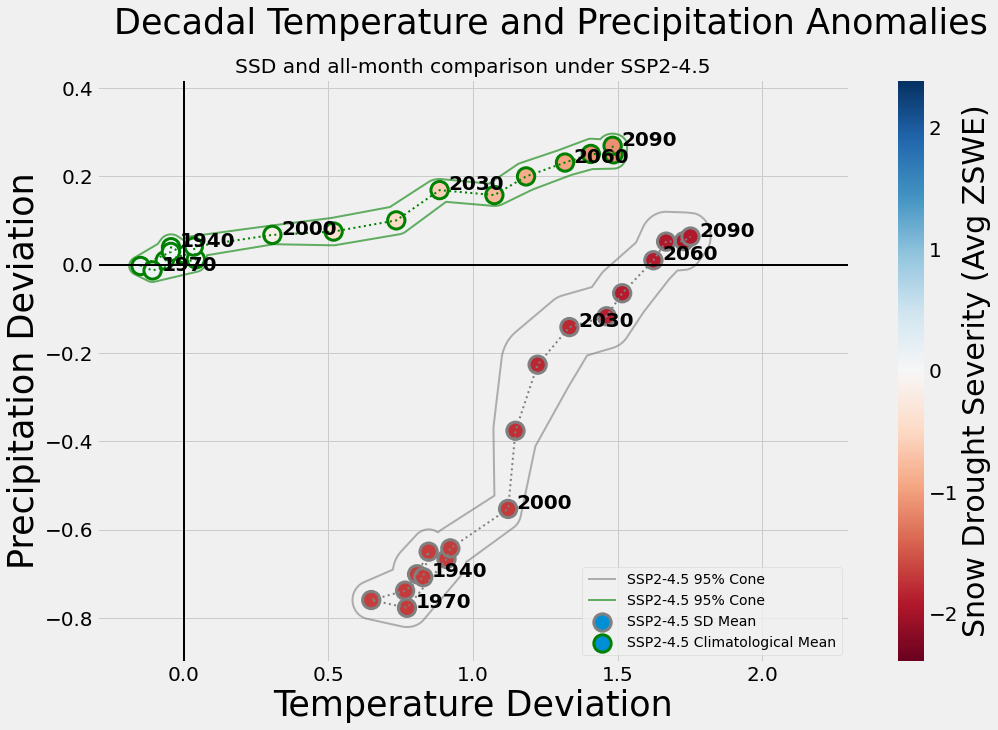

In [6]:
# make phase diagram 
import matplotlib
matplotlib.rc('xtick', labelsize = 20)
matplotlib.rc('ytick', labelsize = 20)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
drought_cm = matplotlib.cm.get_cmap('RdBu')


####### RCP 4.5 #########
plt.plot(temp_mean45,prec_mean45, color='grey', linestyle='dotted', linewidth=2)
im = plt.scatter(temp_mean45, prec_mean45, c=snow_mean45, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='gray', linewidths=3, label="SSP2-4.5 SD Mean")

# add annotations for RCP 4.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    if i%3 ==2:
        plt.annotate(txt, (temp_mean45[i]+0.03, prec_mean45[i]), fontsize=20, weight = 'bold')
    
# add CIs for RCP 4.5
px245, py245 = cone_45.exterior.xy
plt.plot(px245, py245, color='gray', alpha =0.6, linewidth=2, label="SSP2-4.5 95% Cone")


######## RCP 4.5 #########
plt.plot(clim_temp_m45,clim_prec_m45, color='green', linestyle='dotted', linewidth=2)
im = plt.scatter(clim_temp_m45, clim_prec_m45, c=clim_snow_m45, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='green', linewidths=3, label="SSP2-4.5 Climatological Mean")

# add annotations for RCP 4.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    if i%3 ==2:
        plt.annotate(txt, (clim_temp_m45[i]+0.03, clim_prec_m45[i]), fontsize=20, weight= 'bold')
    

# add CIs for RCP 4.5
px245, py245 = clim_cone_45.exterior.xy
plt.plot(px245, py245, color='green', alpha =0.6, linewidth=2, label="SSP2-4.5 95% Cone")


# set axes so comparison is identical
plt.xlim(-0.3,2.3)
plt.ylim(-0.9, 0.42)

plt.axvline(0, color='k', linewidth=2)
plt.axhline(0, color='k', linewidth=2)
plt.xlabel("Temperature Deviation", fontsize = 35)
plt.ylabel("Precipitation Deviation", fontsize =35)
plt.suptitle("Decadal Temperature and Precipitation Anomalies", fontsize =35)
plt.title("SSD and all-month comparison under SSP2-4.5")
plt.legend()
cbar = plt.colorbar()
cbar.set_label(label="Snow Drought Severity (Avg ZSWE)", size = 30);
cbar.ax.tick_params(labelsize = 20)
#plt.savefig("/home/Julian.Schmitt/plots/Drought_1.3_andclim_phase_diagram_ssp2_4.5.png", dpi=250)

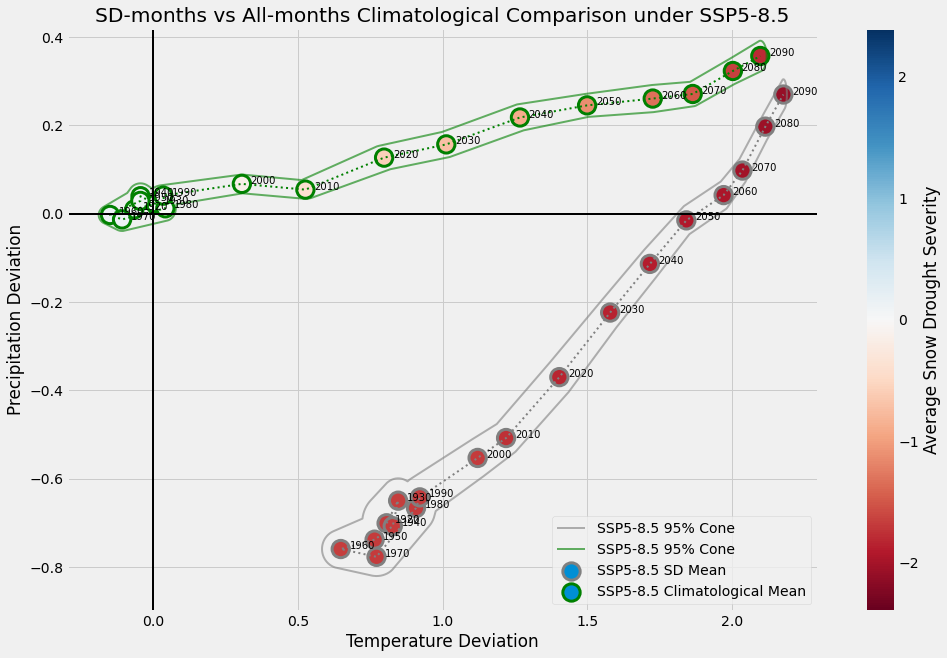

In [12]:
# make phase diagram 
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
drought_cm = matplotlib.cm.get_cmap('RdBu')

# def add_cone(poly, fig = fig, color:str='gray'):
#     px, py = poly.exterior.xy
#     cone = plt.plot(px, py, color=color, alpha =0.6, linewidth=2, label="RCP 4.5 95% Cone")
#     return cone

######### RCP8.5 ##########
# scatter and dotted line for RCP 8.5
plt.plot(temp_mean85,prec_mean85, color='grey', linestyle='dotted', linewidth=2)
im = plt.scatter(temp_mean85, prec_mean85, c=snow_mean85, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='gray', linewidths=3, label="SSP5-8.5 SD Mean")

# add annotations for RCP 8.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    plt.annotate(txt, (temp_mean85[i]+0.03, prec_mean85[i]), fontsize=10)
    
# add CIs for RCP 8.5
px, py = cone_85.exterior.xy
plt.plot(px, py, color='gray', alpha =0.6, linewidth=2, label="SSP5-8.5 95% Cone")


# add climatological data
# scatter and dotted line for RCP 8.5
plt.plot(clim_temp_m85,clim_prec_m85, color='green', linestyle='dotted', linewidth=2)
plt.scatter(clim_temp_m85, clim_prec_m85, c=clim_snow_m85, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='green', linewidths=3, label="SSP5-8.5 Climatological Mean")

# add annotations for RCP 8.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    plt.annotate(txt, (clim_temp_m85[i]+0.03, clim_prec_m85[i]), fontsize=10)
    

# add CIs for RCP 8.5
px, py = clim_cone_85.exterior.xy
plt.plot(px, py, color='green', alpha =0.6, linewidth=2, label="SSP5-8.5 95% Cone")

# set axes so comparison is identical
plt.xlim(-0.3,2.3)
plt.ylim(-0.9, 0.42)

plt.axvline(0, color='k', linewidth=2)
plt.axhline(0, color='k', linewidth=2)
plt.xlabel("Temperature Deviation")
plt.ylabel("Precipitation Deviation")
plt.title("SD-months vs All-months Climatological Comparison under SSP5-8.5")
plt.legend()
plt.colorbar(im, label="Average Snow Drought Severity");
#plt.savefig("/home/Julian.Schmitt/plots/Drought_1.3_andclim_phase_diagram_ssp2_4.5.png", dpi=250)

# combine both into panel image

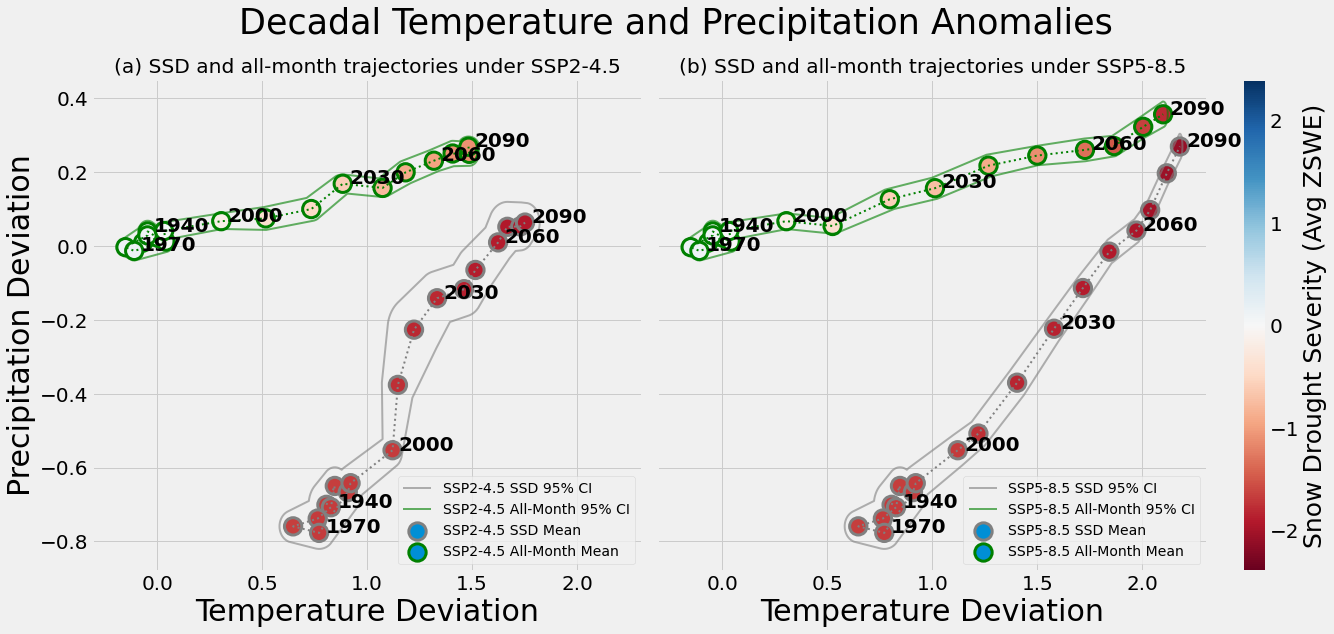

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,9), sharex = True, sharey = True,
                              gridspec_kw = {'width_ratios': [0.8,1]})
fig.suptitle('Horizontally stacked subplots')
ax1.set_xlabel("Temperature Deviation", fontsize = 30)
ax1.set_ylabel("Precipitation Deviation", fontsize =30)
ax2.set_xlabel("Temperature Deviation", fontsize = 30)


fig.suptitle("Decadal Temperature and Precipitation Anomalies", fontsize =35)
ax1.set_title("(a) SSD and all-month trajectories under SSP2-4.5")
ax2.set_title("(b) SSD and all-month trajectories under SSP5-8.5")


######################## SSP2-4.5 #########################
ax1.plot(temp_mean45,prec_mean45, color='grey', linestyle='dotted', linewidth=2)
im = ax1.scatter(temp_mean45, prec_mean45, c=snow_mean45, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='gray', linewidths=3, label="SSP2-4.5 SSD Mean")

# add annotations for RCP 4.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    if i%3 ==2:
        ax1.annotate(txt, (temp_mean45[i]+0.03, prec_mean45[i]), fontsize=20, weight = 'bold')
    
# add CIs for RCP 4.5
px245, py245 = cone_45.exterior.xy
ax1.plot(px245, py245, color='gray', alpha =0.6, linewidth=2, label="SSP2-4.5 SSD 95% CI")

ax1.plot(clim_temp_m45,clim_prec_m45, color='green', linestyle='dotted', linewidth=2)
im = ax1.scatter(clim_temp_m45, clim_prec_m45, c=clim_snow_m45, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='green', linewidths=3, label="SSP2-4.5 All-Month Mean")

# add annotations for RCP 4.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    if i%3 ==2:
        ax1.annotate(txt, (clim_temp_m45[i]+0.03, clim_prec_m45[i]), fontsize=20, weight= 'bold')
    

# add CIs for RCP 4.5
px245, py245 = clim_cone_45.exterior.xy
ax1.plot(px245, py245, color='green', alpha =0.6, linewidth=2, label="SSP2-4.5 All-Month 95% CI")


######################## SSP5-8.5 #########################
# scatter and dotted line for RCP 8.5
ax2.plot(temp_mean85,prec_mean85, color='grey', linestyle='dotted', linewidth=2)
im = ax2.scatter(temp_mean85, prec_mean85, c=snow_mean85, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='gray', linewidths=3, label="SSP5-8.5 SSD Mean")

# add annotations for RCP 8.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    if i%3 ==2:
        ax2.annotate(txt, (temp_mean85[i]+0.03, prec_mean85[i]), fontsize=20, weight = 'bold')
    
# add CIs for RCP 8.5
px, py = cone_85.exterior.xy
ax2.plot(px, py, color='gray', alpha =0.6, linewidth=2, label="SSP5-8.5 SSD 95% CI")

# scatter and dotted line for RCP 8.5
plt.plot(clim_temp_m85,clim_prec_m85, color='green', linestyle='dotted', linewidth=2)
plt.scatter(clim_temp_m85, clim_prec_m85, c=clim_snow_m85, s=300, cmap=drought_cm, 
            vmin=-2.4, vmax=2.4, edgecolors='green', linewidths=3, label="SSP5-8.5 All-Month Mean")

# add annotations for RCP 8.5
decades = [[str(decade), str(decade +9)] for decade in np.arange(1920, 2100, 10)]
dec_start = [dec[0] for dec in decades]
for i, txt in enumerate(dec_start):
    if i%3 == 2:
        ax2.annotate(txt, (clim_temp_m85[i]+0.03, clim_prec_m85[i]), fontsize=20, weight= 'bold')
    

# add CIs for RCP 8.5
px, py = clim_cone_85.exterior.xy
plt.plot(px, py, color='green', alpha =0.6, linewidth=2, label="SSP5-8.5 All-Month 95% CI")



################### Colorbar and legends #######################
ax1.legend(loc = 'lower right')
ax2.legend(loc = 'lower right')

cbar = plt.colorbar(im, ax = ax2)
cbar.set_label(label="Snow Drought Severity (Avg ZSWE)", size = 25);
cbar.ax.tick_params(labelsize = 20)
plt.subplots_adjust(wspace = 0.05)
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/TP_anomalies.png", dpi = 175)

In [8]:
# Extract values for paper
snow_mean45, prec_mean45, temp_mean45, cone_45 = uncertainty_cone(all_means245, times, 0.95)
snow_mean85, prec_mean85, temp_mean85, cone_85 = uncertainty_cone(all_means, times, 0.95)

clim_snow_m45, clim_prec_m45, clim_temp_m45, clim_cone_45 = uncertainty_cone(all_clim_means45, times, 0.95)
clim_snow_m85, clim_prec_m85, clim_temp_m85, clim_cone_85 = uncertainty_cone(all_clim_means85, times, 0.95)

In [17]:
temp_mean45

array([0.80649656, 0.846443  , 0.82778   , 0.7650688 , 0.6478923 ,
       0.7716706 , 0.90817684, 0.921503  , 1.1213908 , 1.1468426 ,
       1.2234482 , 1.333399  , 1.4619308 , 1.5158925 , 1.6238908 ,
       1.6678874 , 1.7294223 , 1.752051  ], dtype=float32)

In [18]:
prec_mean45

array([-0.70074844, -0.6496329 , -0.7073708 , -0.73786175, -0.75907207,
       -0.77672184, -0.6662684 , -0.64213943, -0.5528807 , -0.37597388,
       -0.22639622, -0.14125982, -0.11680534, -0.06468997,  0.00995888,
        0.05215325,  0.05327857,  0.06360976], dtype=float32)

In [19]:
np.array(snow_mean45)

array([-1.673433 , -1.6635779, -1.6695548, -1.6742767, -1.6573284,
       -1.6722045, -1.6725086, -1.6867105, -1.6873206, -1.7534257,
       -1.8140943, -1.8126773, -1.8564667, -1.8831037, -1.8826461,
       -1.930898 , -1.9326437, -1.9166428], dtype=float32)

In [20]:
clim_temp_m45

array([-0.06629781,  0.00561088, -0.04467434, -0.04519403, -0.15019323,
       -0.10841669,  0.04119685,  0.0339945 ,  0.30588326,  0.51771075,
        0.73451114,  0.88435966,  1.0737747 ,  1.1834308 ,  1.3181419 ,
        1.4074591 ,  1.4861006 ,  1.4828035 ], dtype=float32)

In [21]:
clim_prec_m45

array([ 0.00952062,  0.02217903,  0.03951001,  0.02887787, -0.00296005,
       -0.01304466,  0.01212305,  0.04076171,  0.06739663,  0.07490727,
        0.10026315,  0.16870648,  0.1574866 ,  0.199733  ,  0.23115559,
        0.25062218,  0.24977544,  0.2690382 ], dtype=float32)

In [22]:
np.array(clim_snow_m45)

array([ 0.05984371,  0.02045662,  0.09369639,  0.08741105,  0.14864142,
        0.12115466,  0.01100758,  0.03455335, -0.1574157 , -0.39063185,
       -0.48385292, -0.5981178 , -0.77669173, -0.88775915, -0.9688076 ,
       -1.0963931 , -1.1240251 , -1.1021351 ], dtype=float32)